In [39]:
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import sqrt

def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(features, model.coef_))
    print(*feats, sep="\n")
    
carbon = pd.read_csv('assemblies_data.csv') 
carbon.rename(columns = {'Unnamed: 0': 'name'}, inplace=True)

# Selects 1% of the data
carbon_full = carbon
carbon = carbon.sample(frac=0.01, random_state=0)

print(f'Number of points: {len(carbon)}')
carbon.head(n=5)

Number of points: 80


,name,orient,wwr,glazing,shading,shgc,inf_rate,exterior_mat,exterior_t (in),interior_mat,...,area,payback_linear,Total GWP Linear (kg CO2e / ft2) 50 year,Op GWP Linear (kg CO2e / ft2) 50 year,Total GWP non-linear 2% (kg CO2e / ft2) 50 year,Op GWP non-linear 2% (kg CO2e / ft2) 50 year,Total GWP non-linear 3% (kg CO2e / ft2) 50 year,Op GWP non-linear 3% (kg CO2e / ft2) 50 year,Total GWP non-linear 5% (kg CO2e / ft2) 50 year,Op GWP non-linear 5% (kg CO2e / ft2) 50 year
5215,la_w_60_9_0_residential_glz.json,w,0.6,Triple,0.0,0.25,0.00059,Polyiso,3.0,Cellulose,...,949.900982,1.66,94.261833,91.240904,49.553790,46.532861,34.353055,31.332126,22.181519,19.160590
5378,la_w_20_7_2_residential_glz.json,w,0.2,Triple,0.0,0.25,0.00015,Polyiso,1.0,Cellulose,...,949.900982,1.20,85.325107,83.317548,44.499508,42.491950,30.618805,28.611246,19.504244,17.496685
6053,at_w_0_1_2_office_glz.json,w,0.0,Triple,0.0,0.25,0.00015,Polyiso,0.5,Cellulose,...,2231.761934,0.39,275.658487,273.508573,141.639286,139.489372,96.072758,93.922844,59.586714,57.436800
6982,at_s_80_9_2_office_glz.json,s,0.8,Triple,0.0,0.25,0.00015,Polyiso,5.0,Cellulose,...,2231.761934,0.91,319.812829,314.123944,165.892096,160.203212,113.559047,107.870162,71.654913,65.966028
274,la_e_0_5_2_office_glz.json,e,0.0,Triple,0.0,0.25,0.00015,Polyiso,1.0,Cellulose,...,2231.761934,2.04,75.566133,72.604077,39.990135,37.028079,27.894296,24.932240,18.208912,15.246856


In [41]:
# All of the features of interest
selected_inputs = [
    'wwr',
    'shading',
    'shgc',
    'inf_rate',
    'exterior_t (in)',
    'interior_t (in)',
    'Wall R (ft2 * F * h / BTU)',
    'city_gwp',
    'area'
]
other_inputs = [
    'orient',
    'glazing',
    'exterior_mat',
    'city',
    'program'
]    

# Compute the square and sqrt of each feature
all_features = []
for data_input in selected_inputs:
    square_feat = data_input + '_square'
    sqrt_feat = data_input + '_sqrt'
    
    # Compute the square and square root as two new features
    carbon[square_feat] = carbon[data_input]**2
    carbon[sqrt_feat] = np.sqrt(carbon[data_input])
    all_features.extend([data_input, square_feat, sqrt_feat])


# Split the data into features and GWP
gwp = carbon['Total GWP non-linear 2% (kg CO2e / ft2) 50 year']
# other = carbon['city', 'program']
# features = list(loans.columns)
# features.remove('safe_loans')
# features
all_features = all_features + other_inputs
carbon = carbon[all_features]
carbon = pd.get_dummies(carbon)
# carbon.insert(1, other)

carbon.head()

KeyError: 'Total GWP non-linear 2% (kg CO2e / ft2) 50 year'

In [42]:
# split data
train_and_validation_data, test_data, train_and_validation_gwp, test_gwp = \
    train_test_split(carbon, gwp, test_size=.20, random_state=6)
train_data, validation_data, train_gwp, validation_gwp = \
    train_test_split(train_and_validation_data,
                     train_and_validation_gwp, test_size=.125, random_state=6)

# standardization
train_scaler = StandardScaler().fit(train_data)
train_data = train_scaler.transform(train_data)
validation_data = train_scaler.transform(validation_data)
test_data = train_scaler.transform(test_data)

In [43]:
# Linear Regression
linear_model = LinearRegression().fit(train_data, train_gwp)
predict_gwp = linear_model.predict(test_data)
test_rmse = sqrt(mse(predict_gwp, test_gwp))
test_rmse

11.899192743521898

      l2_penalty                                  model  train_rmse  \
0        0.00001     Ridge(alpha=1e-05, random_state=0)    6.240425   
1        0.00010    Ridge(alpha=0.0001, random_state=0)    6.240562   
2        0.00100     Ridge(alpha=0.001, random_state=0)    6.248984   
3        0.01000      Ridge(alpha=0.01, random_state=0)    6.371385   
4        0.10000       Ridge(alpha=0.1, random_state=0)    7.126154   
5        1.00000                  Ridge(random_state=0)    7.965087   
6       10.00000      Ridge(alpha=10.0, random_state=0)    9.209517   
7      100.00000     Ridge(alpha=100.0, random_state=0)   22.409163   
8     1000.00000    Ridge(alpha=1000.0, random_state=0)   53.125881   
9    10000.00000   Ridge(alpha=10000.0, random_state=0)   64.899286   
10  100000.00000  Ridge(alpha=100000.0, random_state=0)   66.482546   

    validation_rmse  
0          7.468187  
1          7.483834  
2          7.620101  
3          8.048701  
4          8.184548  
5          7.96

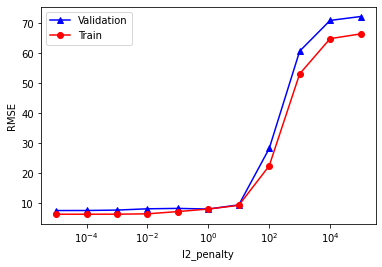

In [44]:
# Ridge Regression
l2_penalty = np.logspace(-5, 5, 11, base=10)
data = []
for l2 in l2_penalty:
    ridge_model = Ridge(l2, random_state=0).fit(train_data, train_gwp)
    train_predict_gwp = ridge_model.predict(train_data)
    train_rmse = sqrt(mse(train_predict_gwp, train_gwp))
    validation_predict_gwp = ridge_model.predict(validation_data)
    validation_rmse = sqrt(mse(validation_predict_gwp, validation_gwp))
    data.append({
        'l2_penalty': l2,
        'model': ridge_model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse
    })
ridge_data = pd.DataFrame(data)

# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['validation_rmse'],
         'b-^', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty')
plt.ylabel('RMSE')
plt.legend()

print(ridge_data)

In [45]:
index = ridge_data['validation_rmse'].idxmin()
best_row = ridge_data.loc[index]
best_l2 = best_row['validation_rmse']

ridge_predict = best_row['model'].predict(test_data)
test_rmse = sqrt(mse(ridge_predict, test_gwp))
print(test_rmse)

print_coefficients(best_row['model'], all_features)
best_row
# We can see that shading and shgc were determined by the ridge 
# regression model to have a negligible effect upon the prediction 
# of 50yr 2% reductions GWP total value.

11.285752568359365
('wwr', 43.481032109906835)
('wwr_square', -17.13512634744511)
('wwr_sqrt', -20.34951504890915)
('shading', 0.0)
('shading_square', 0.0)
('shading_sqrt', 0.0)
('shgc', 0.0)
('shgc_square', 0.0)
('shgc_sqrt', 0.0)
('inf_rate', 0.25025037634659425)
('inf_rate_square', -0.16983358645729982)
('inf_rate_sqrt', 0.5117438325233271)
('exterior_t (in)', 95.88891671327048)
('exterior_t (in)_square', 17.00395491752215)
('exterior_t (in)_sqrt', 1.678435790015055)
('interior_t (in)', 163.54182261922304)
('interior_t (in)_square', -28.82680374582158)
('interior_t (in)_sqrt', -27.074928440096265)
('Wall R (ft2 * F * h / BTU)', -30.27062388003124)
('Wall R (ft2 * F * h / BTU)_square', -60.03786009699455)
('Wall R (ft2 * F * h / BTU)_sqrt', -108.1167320020721)
('city_gwp', 14.905968896538937)
('city_gwp_square', 13.473921802421344)
('city_gwp_sqrt', 15.425312043460263)
('area', 0.4329385879477478)
('area_square', 0.4329385885979699)
('area_sqrt', 0.4329385888578462)


l2_penalty                                      1e-05
model              Ridge(alpha=1e-05, random_state=0)
train_rmse                                    6.24042
validation_rmse                               7.46819
Name: 0, dtype: object

/Users/preston/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228.3093719914475, tolerance: 24.887594223028575
  model = cd_fast.enet_coordinate_descent(
/Users/preston/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227.4138930188008, tolerance: 24.887594223028575
  model = cd_fast.enet_coordinate_descent(
/Users/preston/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1217.0978216002761, tolerance: 24.887594223028575
  model = cd_fast.enet_coordinate_descent(
/Users/preston/opt/anaconda3/lib/python3.8/site-packages/skle

      l1_penalty                                  model  train_rmse  \
0        0.00001     Lasso(alpha=1e-05, random_state=0)    6.623599   
1        0.00010    Lasso(alpha=0.0001, random_state=0)    6.623862   
2        0.00100     Lasso(alpha=0.001, random_state=0)    6.626561   
3        0.01000      Lasso(alpha=0.01, random_state=0)    6.652960   
4        0.10000       Lasso(alpha=0.1, random_state=0)    7.877640   
5        1.00000                  Lasso(random_state=0)    9.320389   
6       10.00000      Lasso(alpha=10.0, random_state=0)   20.130016   
7      100.00000     Lasso(alpha=100.0, random_state=0)   66.664933   
8     1000.00000    Lasso(alpha=1000.0, random_state=0)   66.664933   
9    10000.00000   Lasso(alpha=10000.0, random_state=0)   66.664933   
10  100000.00000  Lasso(alpha=100000.0, random_state=0)   66.664933   

    validation_rmse  
0          8.251152  
1          8.251611  
2          8.254863  
3          8.264331  
4          8.166447  
5          9.12

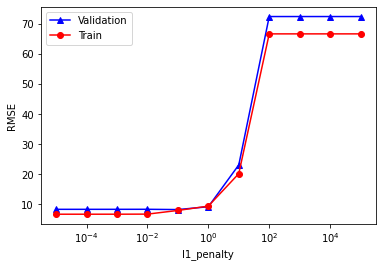

In [46]:

l1_penalty = np.logspace(-5, 5, 11, base=10)
data = []
for l1 in l1_penalty:
    lasso_model = Lasso(l1, random_state=0).fit(train_data, train_gwp)
    train_predict_gwp = lasso_model.predict(train_data)
    train_rmse = sqrt(mse(train_predict_gwp, train_gwp))
    validation_predict_gwp = lasso_model.predict(validation_data)
    validation_rmse = sqrt(mse(validation_predict_gwp, validation_gwp))
    data.append({
        'l1_penalty': l1,
        'model': lasso_model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse
    })
lasso_data = pd.DataFrame(data)

plt.plot(lasso_data['l1_penalty'], lasso_data['validation_rmse'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty')
plt.ylabel('RMSE')
plt.legend()

print(lasso_data)

In [47]:
# Coefficient Inspection
index = lasso_data['validation_rmse'].idxmin()
best_row = lasso_data.loc[index]
best_l1 = best_row['validation_rmse']

lasso_predict = best_row['model'].predict(test_data)
test_rmse = sqrt(mse(lasso_predict, test_gwp))
print(test_rmse)

print_coefficients(best_row['model'], all_features)
best_row

9.068030122195836
('wwr', 12.943543460460804)
('wwr_square', 0.0)
('wwr_sqrt', -5.269267420152445)
('shading', 0.0)
('shading_square', 0.0)
('shading_sqrt', 0.0)
('shgc', 0.0)
('shgc_square', 0.0)
('shgc_sqrt', 0.0)
('inf_rate', 0.0)
('inf_rate_square', -0.0)
('inf_rate_sqrt', 1.517051871455595)
('exterior_t (in)', 1.2813547643201109)
('exterior_t (in)_square', 7.017248120454177)
('exterior_t (in)_sqrt', -2.7555414599880734)
('interior_t (in)', 0.0)
('interior_t (in)_square', 6.337250407837879)
('interior_t (in)_sqrt', 0.0)
('Wall R (ft2 * F * h / BTU)', 0.0)
('Wall R (ft2 * F * h / BTU)_square', 0.0)
('Wall R (ft2 * F * h / BTU)_sqrt', -14.18461179272406)
('city_gwp', 44.7191730035336)
('city_gwp_square', 0.0)
('city_gwp_sqrt', 11.248001590421056)
('area', -0.15115960396808767)
('area_square', -0.0)
('area_sqrt', -4.7580986769649563e-17)


l1_penalty                                      0.1
model              Lasso(alpha=0.1, random_state=0)
train_rmse                                  7.87764
validation_rmse                             8.16645
Name: 4, dtype: object

In [9]:
for feature, coef in zip(all_features, best_row['model'].coef_):
    if abs(coef) <= 10 ** -17:
        print(feature)
# The LASSO model also identified shading and shgc as neglible features with respect to the output gwp.

shading
shading_square
shading_sqrt
shgc
shgc_square
shgc_sqrt


In [54]:
# Compare predictions

gwp.sort_index(inplace=True)

selected_ridge_model = Ridge(0.00001, random_state=0).fit(train_data, train_gwp)
ridge_gwp_predict = selected_ridge_model.predict(test_data)

selected_lasso_model = Lasso(0.00010, random_state=0).fit(train_data, train_gwp)
lasso_gwp_predict = selected_lasso_model.predict(test_data)

ridge_gwp_predict = pd.DataFrame(ridge_gwp_predict)
# print("true_gwp          ", "pred_gwp")
# for true, predict in zip(gwp, lasso_gwp_predict):
#     print(true, predict)

list = ridge_gwp_predict[0].tolist()
list
# gwp
    
    
# ridge_gwp_predict.head()
# lasso_gwp_predict['gwp_true'] = gwp
# print(gwp, ' ', lasso_gwp_predict, '\n')
# lasso_gwp_predict = pd.DataFrame(lasso_gwp_predict)
# lasso_gwp_predict.insert(1, gwp, True)
# type(lasso_gwp_predict)
# lasso_gwp_predict = lasso_gwp_predict.merge(gwp,left_index=True, right_index=True)

# lasso_gwp_predict.head()
# lasso_gwp_predict = pd.Series(lasso_gwp_predict)
# lasso_comparison = pd.concat([lasso_gwp_predict, gwp],axis=1)
# lasso_comparison.rename(columns = {0: 'gwp_predicted'}, inplace=True)
# lasso_comparison.rename(columns = {'Total GWP non-linear 2% (kg CO2e / ft2) 50 year': 'gwp_true'}, inplace=True)
# gwp
# gwp.head()


# print(gwp)


/Users/preston/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227.4138930188008, tolerance: 24.887594223028575
  model = cd_fast.enet_coordinate_descent(


[52.911642538084095,
 42.39320005291688,
 187.15738167319495,
 191.73970754222563,
 170.54839328992256,
 231.24865500722848,
 208.86047493283797,
 37.37519844732334,
 57.15945752052956,
 182.75292290639948,
 193.44319662386224,
 54.29479219027158,
 55.07391865738791,
 179.68195677443865,
 63.62959990587912,
 213.0003086999156]